# transient_margins.ipynb

#### A code to find the best sigma margins to identify transient sources

#### Import all the dependencies and generic setup

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['legend.loc'] = 'best'
from matplotlib.ticker import NullFormatter
from matplotlib.font_manager import FontProperties
import os
import glob
import numpy as np
import pandas as pd
from scipy import optimize
import tkp.db
import logging
query_loglevel = logging.WARNING  # Set to INFO to see queries, otherwise WARNING
import sqlalchemy
from sqlalchemy import *
from sqlalchemy.orm import relationship
import sys
sys.path.append('../')
from dblogin import * # This file contains all the variables required to connect to the database
from database_tools import dbtools
from tools import tools
from plotting import plot_varib_params as pltvp
from machine_learning import train_sigma_margin
from machine_learning import generic_tools

/home/antoniar/JupyterEnv/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


##### The input data and thresholds

In [2]:
tests = False
plots = False
path='ml_csv_files/'
stableData = path+'stable_sources.csv'
simulatedData = path+'sim_*_trans_data.csv'
detection_threshold = 8.

#### Load the data and give appropriate labels

In [3]:
all_data = generic_tools.load_data(stableData,simulatedData)

#### Identify all the new sources detected during the pipeline run

In [4]:
all_data=all_data.loc[(all_data['ttype'] == 0) | (all_data['ttype'] == 1)]

#### Create a histogram of the detection thresholds assuming the source was found in the lowest RMS region of image

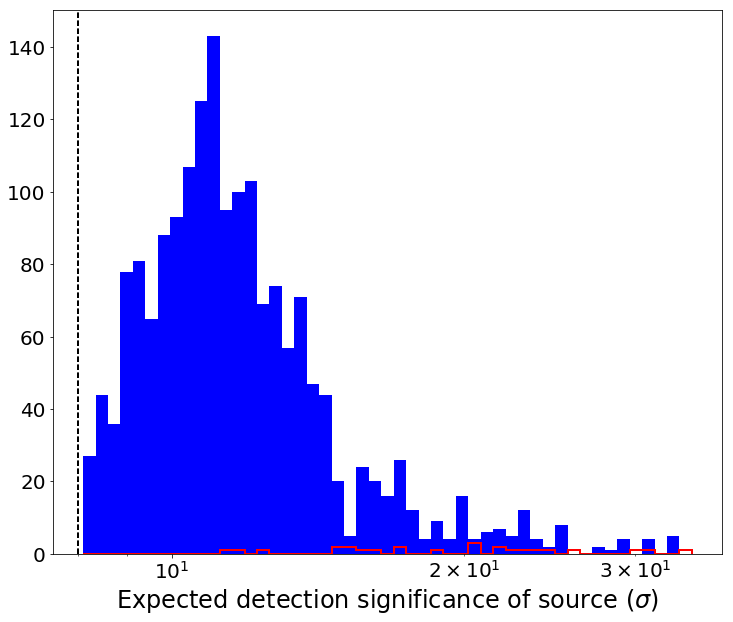

In [5]:
x=all_data.loc[(all_data['ttype'] == 0) & (all_data['variable'] == 0)]
x2=all_data.loc[(all_data['ttype'] == 0) & (all_data['variable'] == 1)]
plt.figure(figsize=(12,10))
plt.xscale('log')
bins=np.logspace(np.log10(min(x['minRmsSigma'])), np.log10(max(x2['minRmsSigma'])), num=50, endpoint=True, base=10.0)
plt.hist(x['minRmsSigma'], bins=bins, histtype='stepfilled', color='b')
plt.hist(x2['minRmsSigma'], bins=bins, histtype='step', linewidth=2, color='r')
plt.xlabel(r'Expected detection significance of source ($\sigma$)', fontsize=24)
plt.axvline(x=detection_threshold, linestyle='--', linewidth=2, color='k')

#### Create a histogram of the detection thresholds assuming the source was found in the highest RMS region of image

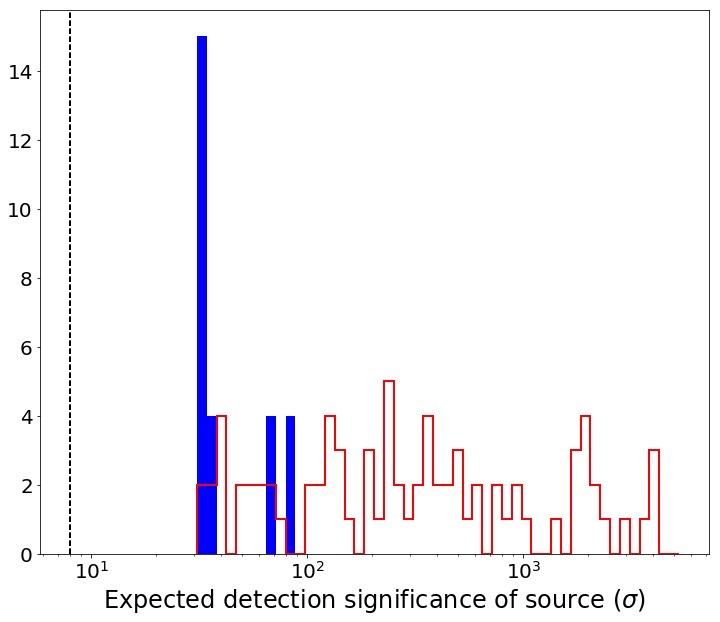

In [6]:
x=all_data.loc[(all_data['ttype'] == 1) & (all_data['variable'] == 0)]
x2=all_data.loc[(all_data['ttype'] == 1) & (all_data['variable'] == 1)]
plt.figure(figsize=(12,10))
plt.xscale('log')
bins=np.logspace(np.log10(min(x['minRmsSigma'])), np.log10(max(x2['minRmsSigma'])), num=50, endpoint=True, base=10.0)
plt.hist(x['minRmsSigma'], bins=bins, histtype='stepfilled', color='b')
plt.hist(x2['minRmsSigma'], bins=bins, histtype='step', linewidth=2, color='r')
plt.xlabel(r'Expected detection significance of source ($\sigma$)', fontsize=24)
plt.axvline(x=detection_threshold, linestyle='--', linewidth=2, color='k')

#### Find the best margins to maximise detection and reliability

In [7]:
best_data=all_data[['minRmsSigma','variable']].as_matrix()
worst_data=all_data[['maxRmsSigma','variable']].as_matrix()

best_plot_data, worst_plot_data, sigBest, sigWorst = train_sigma_margin.find_sigma_margin(best_data,worst_data, detection_threshold)

#### Search and identify the optimal sigma margin for the best and worst parts of the image

In [9]:
sigWorst, sigBest = train_sigma_margin.plot_diagnostic(best_plot_data,worst_plot_data,path)

Best sigma parameters:
Worst RMS = 2.0 Precision = 0.811320754717 Recall = 0.788990825688
Best RMS = 34.0 Precision = 0.890243902439 Recall = 0.669724770642


#### Identify the ids of interesting transient candidates assuming they're in the worst part of the image

In [10]:
all_data.loc[(all_data['maxRmsSigma'] >= sigWorst+detection_threshold) & (all_data['variable']==0)]

,#Runcat,Dec,RA,V,detectionThreshold,detectionThreshold,dpts,eta,flux,fluxrat,freq,label,maxRmsSigma,minRmsSigma,ttype,variable
5590,11011,52.377728,73.199764,0.092414,8.0,NaN,44,0.704490,0.558011,1.116309,185,stable,14.687526,33.832917,1,0
5632,12687,53.022248,147.987477,0.287732,8.0,NaN,28,4.177800,0.670679,1.592606,185,stable,14.971562,33.082775,1,0
5633,12688,53.211031,148.200683,0.453435,8.0,NaN,28,25.698784,1.373934,1.958374,185,stable,30.670319,67.772437,1,0
5897,12661,51.909193,146.904230,0.357763,8.0,NaN,20,13.298643,0.626075,1.507446,185,stable,13.975874,30.882595,1,0
6678,11170,52.951598,80.908429,0.070765,8.0,NaN,32,3.307862,1.405780,1.108681,185,stable,15.210170,81.445325,1,0
12272,11011,52.377728,73.199764,0.090554,8.0,NaN,44,0.839497,0.732807,1.096281,156,stable,14.687526,33.832917,1,0
12314,12687,53.022248,147.987477,0.103588,8.0,NaN,36,1.257283,0.582042,1.132270,156,stable,14.971562,33.082775,1,0
12315,12688,53.211031,148.200683,0.123575,8.0,NaN,36,3.853048,0.952376,1.144265,156,stable,30.670319,67.772437,1,0
12579,12661,51.909193,146.904230,0.236243,8.0,NaN,40,13.530331,0.688051,1.234087,156,stable,13.975874,30.882595,1,0
13351,11170,52.951598,80.908429,0.050179,8.0,NaN,36,1.987713,1.429351,1.061776,156,stable,15.210170,81.445325,1,0


#### Identify the ids of interesting transient candidates assuming they're in the best part of the image

In [11]:
all_data.loc[(all_data['minRmsSigma'] >= sigBest+detection_threshold) & (all_data['variable']==0)]

,#Runcat,Dec,RA,V,detectionThreshold,detectionThreshold,dpts,eta,flux,fluxrat,freq,label,maxRmsSigma,minRmsSigma,ttype,variable
5633,12688,53.211031,148.200683,0.453435,8.0,NaN,28,25.698784,1.373934,1.958374,185,stable,30.670319,67.772437,1,0
6678,11170,52.951598,80.908429,0.070765,8.0,NaN,32,3.307862,1.405780,1.108681,185,stable,15.210170,81.445325,1,0
6698,13826,53.196818,97.624113,0.000000,8.0,NaN,1,0.000000,0.518790,1.000000,185,stable,6.497714,46.698863,0,0
12315,12688,53.211031,148.200683,0.123575,8.0,NaN,36,3.853048,0.952376,1.144265,156,stable,30.670319,67.772437,1,0
13351,11170,52.951598,80.908429,0.050179,8.0,NaN,36,1.987713,1.429351,1.061776,156,stable,15.210170,81.445325,1,0
18882,12688,53.211031,148.200683,0.258606,8.0,NaN,40,21.364829,2.138145,1.701261,124,stable,30.670319,67.772437,1,0
19916,11170,52.951598,80.908429,0.074400,8.0,NaN,48,3.651530,1.606320,1.113709,124,stable,15.210170,81.445325,1,0
25516,12688,53.211031,148.200683,0.156576,8.0,NaN,36,6.651539,0.992492,1.180357,149,stable,30.670319,67.772437,1,0
26557,11170,52.951598,80.908429,0.054853,8.0,NaN,28,2.612899,1.495165,1.052874,149,stable,15.210170,81.445325,1,0


#### And the best thresholds are:

In [12]:
print('Lowest RMS region threshold: '+str(sigBest+detection_threshold)+' sigma')
print('Highest RMS region threshold: '+str(sigWorst+detection_threshold)+' sigma')

Lowest RMS region threshold: 42.0 sigma
Highest RMS region threshold: 10.0 sigma
